In [1]:
%load_ext autoreload
%autoreload 2

# Import all required library
import os
import time
import math

import numpy as np
import pandas as pd

import tqdm

import warnings
warnings.filterwarnings("ignore")

import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AdamW, 
    get_linear_schedule_with_warmup,
    DataCollatorWithPadding,
    Trainer, 
    TrainingArguments,
    AutoModelForCausalLM,
    set_seed
)

from peft import (
    LoraConfig, 
    get_peft_model, 
    TaskType,
    PeftModel,
    AdaLoraConfig,
    AdaLoraModel,
    VeraConfig,
)

import datasets 

In [2]:
seed = 42
#reproducibility
def _seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    set_seed(seed)

_seed(seed)

In [3]:
# Define a function that can print the trainable parameters 
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params} \nall model parameters: {all_model_params}{"\n"}percentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

In [4]:
full_data = pd.read_csv("7-prompts.csv")
print(f"We have {len(full_data)} samples") # Number of data we have

print(full_data.sample(5,random_state=19))

# full_data = full_data.head(1000) # Subset the data for testing the code

We have 17251 samples
                                                    text  label
8511   The value of using this technology to read stu...      0
5837   the author supports his ideas very well becaus...      0
17230  Dear Senator,\n\nI am writing to you today to ...      1
12936  Dear Mr./Mrs. Senator,\n\nThe Electoral Colleg...      0
15253  "The Challenge of Exploring Venus" by James Tr...      1


In [5]:
from sklearn.model_selection import train_test_split

# Split it when augmented data is ready
X_train, X_val, y_train, y_val = train_test_split(full_data["text"],
                                                  full_data["label"],
                                                  test_size=0.3,
                                                  stratify=full_data["label"],
                                                  random_state=42)
print(f"We have {len(X_train)} training samples")
print(f"We have {len(X_val)} validation samples")
print("----------------------------")
count = full_data["label"].value_counts()
print(f"Number of Essays written by Human: {count[0]}")
print(f"Number of Essays generated by LLM: {count[1]}")

X_train.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
X_val.reset_index(drop = True, inplace = True)
y_val.reset_index(drop = True, inplace = True)

We have 12075 training samples
We have 5176 validation samples
----------------------------
Number of Essays written by Human: 14247
Number of Essays generated by LLM: 3004


In [6]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load DistilBERT model and tokenizer (uncased)
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", return_dict=True, num_labels=2
)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Print the number of trainable parameters
print(print_number_of_trainable_model_parameters(model))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable model parameters: 66955010 
all model parameters: 66955010
percentage of trainable model parameters: 100.00%


In [7]:
def print_trainable_layers(model):
    """
    Print names of all trainable layers in a PyTorch model.
    
    Args:
        model: PyTorch model (nn.Module)
    """
    trainable_layers = [
        name for name, param in model.named_parameters()
        if param.requires_grad
    ]
    
    print("Trainable layers:")
    for layer in trainable_layers:
        print(f"  - {layer}")

print_trainable_layers(model)

Trainable layers:
  - distilbert.embeddings.word_embeddings.weight
  - distilbert.embeddings.position_embeddings.weight
  - distilbert.embeddings.LayerNorm.weight
  - distilbert.embeddings.LayerNorm.bias
  - distilbert.transformer.layer.0.attention.q_lin.weight
  - distilbert.transformer.layer.0.attention.q_lin.bias
  - distilbert.transformer.layer.0.attention.k_lin.weight
  - distilbert.transformer.layer.0.attention.k_lin.bias
  - distilbert.transformer.layer.0.attention.v_lin.weight
  - distilbert.transformer.layer.0.attention.v_lin.bias
  - distilbert.transformer.layer.0.attention.out_lin.weight
  - distilbert.transformer.layer.0.attention.out_lin.bias
  - distilbert.transformer.layer.0.sa_layer_norm.weight
  - distilbert.transformer.layer.0.sa_layer_norm.bias
  - distilbert.transformer.layer.0.ffn.lin1.weight
  - distilbert.transformer.layer.0.ffn.lin1.bias
  - distilbert.transformer.layer.0.ffn.lin2.weight
  - distilbert.transformer.layer.0.ffn.lin2.bias
  - distilbert.transformer

In [8]:
# Define the LoRA Configuration
lora_config = LoraConfig(
    r=8, # Rank Number
    lora_alpha=32, # Alpha (Scaling Factor)
    lora_dropout=0.05, # Dropout Prob for Lora
    target_modules=["q_lin", "k_lin","v_lin"], # Which layer to apply LoRA, usually only apply on MultiHead Attention Layer
    bias='none',
    # use_dora=True,
    # init_lora_weights='pissa',
    task_type=TaskType.SEQ_CLS, # Seqence to Classification Task

)
# Define the LoRA Configuration
# lora_config = AdaLoraConfig(
#     init_r=12, # Rank Number
    
#     lora_alpha=32, # Alpha (Scaling Factor)
#     lora_dropout=0.05, # Dropout Prob for Lora
#     target_modules=["q_lin", "k_lin","v_lin"], # Which layer to apply LoRA, usually only apply on MultiHead Attention Layer
#     bias='none',
#     # init_lora_weights='pissa',
#     task_type=TaskType.SEQ_CLS, # Seqence to Classification Task

# )
# lora_config = AdaLoraConfig(
#     task_type=TaskType.SEQ_CLS,
#     r=8,  # Initial rank
#     lora_alpha=32,
#     target_r=4,  # Target rank after pruning
#     init_r=12,  # Initial rank before pruning
#     beta1=0.85,  # Hyperparameter for updating importance score
#     beta2=0.85,  # Hyperparameter for updating gradient scale
#     tinit=200,  # Warmup steps
#     tfinal=1000,  # When to stop rank allocation
#     deltaT=10,  # Time internal for rank allocation
#     lora_dropout=0.1,
#     inference_mode=False,
#     bias="none",
#     modules_to_save=None,
#     # Target modules for DistilBERT
#     target_modules=["q_lin", "k_lin", "v_lin",]
# )

# lora_config = VeraConfig(r=256,target_modules=["q_lin", "k_lin","v_lin"], # Which layer to apply LoRA, usually only apply on MultiHead Attention Layer
#     bias='none',
#     # init_lora_weights='pissa',
#     task_type=TaskType.SEQ_CLS, # Seqence to Classification Task
# )

In [9]:
# Get our LoRA-enabled model
peft_model = get_peft_model(model, 
                            lora_config,)
                            

# Reduced trainble parameters
print(print_number_of_trainable_model_parameters(peft_model))
print_trainable_layers(peft_model)

trainable model parameters: 813332 
all model parameters: 67768342
percentage of trainable model parameters: 1.20%
Trainable layers:
  - base_model.model.distilbert.transformer.layer.0.attention.q_lin.lora_A.default.weight
  - base_model.model.distilbert.transformer.layer.0.attention.q_lin.lora_B.default.weight
  - base_model.model.distilbert.transformer.layer.0.attention.q_lin.lora_S.default.magnitude
  - base_model.model.distilbert.transformer.layer.0.attention.k_lin.lora_A.default.weight
  - base_model.model.distilbert.transformer.layer.0.attention.k_lin.lora_B.default.weight
  - base_model.model.distilbert.transformer.layer.0.attention.k_lin.lora_S.default.magnitude
  - base_model.model.distilbert.transformer.layer.0.attention.v_lin.lora_A.default.weight
  - base_model.model.distilbert.transformer.layer.0.attention.v_lin.lora_B.default.weight
  - base_model.model.distilbert.transformer.layer.0.attention.v_lin.lora_S.default.magnitude
  - base_model.model.distilbert.transformer.laye

In [10]:
s = 0
for name,val in peft_model.named_parameters():
        print(name)
        s +=1


base_model.model.distilbert.embeddings.word_embeddings.weight
base_model.model.distilbert.embeddings.position_embeddings.weight
base_model.model.distilbert.embeddings.LayerNorm.weight
base_model.model.distilbert.embeddings.LayerNorm.bias
base_model.model.distilbert.transformer.layer.0.attention.q_lin.base_layer.weight
base_model.model.distilbert.transformer.layer.0.attention.q_lin.base_layer.bias
base_model.model.distilbert.transformer.layer.0.attention.q_lin.lora_A.default.weight
base_model.model.distilbert.transformer.layer.0.attention.q_lin.lora_B.default.weight
base_model.model.distilbert.transformer.layer.0.attention.q_lin.lora_S.default.magnitude
base_model.model.distilbert.transformer.layer.0.attention.k_lin.base_layer.weight
base_model.model.distilbert.transformer.layer.0.attention.k_lin.base_layer.bias
base_model.model.distilbert.transformer.layer.0.attention.k_lin.lora_A.default.weight
base_model.model.distilbert.transformer.layer.0.attention.k_lin.lora_B.default.weight
base_

In [11]:
# Tokenize function
def tokenize_func(data):
    return tokenizer(
            data['texts'],
            max_length=512,
            padding='max_length',
            return_attention_mask=True,
            truncation=True
        )

In [12]:
# Tokenize the Training Data
train_dataset = datasets.Dataset.from_pandas(pd.DataFrame({"texts":X_train,"labels":y_train}))
train_dataset = train_dataset.map(
    tokenize_func,
    batched=True,
    remove_columns=["texts"]
)
train_dataset

Map:   0%|          | 0/12075 [00:00<?, ? examples/s]

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 12075
})

In [13]:
# Tokenize the Validation Data
val_dataset = datasets.Dataset.from_pandas(pd.DataFrame({"texts":X_val,"labels":y_val}))
val_dataset = val_dataset.map(
    tokenize_func,
    batched=True,
    remove_columns=["texts"]
)

val_dataset

Map:   0%|          | 0/5176 [00:00<?, ? examples/s]

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 5176
})

In [14]:
from datasets import load_dataset
def preprocess_glue(task_name='qnli'):
    """
    Preprocesses GLUE tasks for fine-tuning DistilBERT with HuggingFace's Trainer class.
    
    Args:
        task_name (str): Name of the GLUE task ('mnli', 'sst2', 'qqp', 'qnli')
        
    Returns:
        tuple: (train_dataset, eval_dataset) preprocessed datasets ready for Trainer
    """
    
    # Check if cached dataset exists
    folder_path = f"/home/marco.garofalo/flower-for-tests/datasets/{task_name}"
    if os.path.isdir(folder_path):
        from datasets import load_from_disk
        dataset_dict = load_from_disk(folder_path)
    else:
        dataset_dict = load_dataset("glue", task_name)
        # Save dataset for future use
        os.makedirs(folder_path, exist_ok=True)
        dataset_dict.save_to_disk(folder_path)

    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    
    # Define tokenization function based on task
    def tokenize_func(examples):
        if task_name == "mnli":
            return tokenizer(
                examples["premise"],
                examples["hypothesis"],
                max_length=512,
                padding=True,
                truncation=True,
                return_tensors="pt"
            )
        elif task_name == "sst2":
            return tokenizer(
                examples["sentence"],
                max_length=512,
                padding=True,
                truncation=True,
                return_tensors="pt"
            )
        elif task_name == "qqp":
            return tokenizer(
                examples["question1"],
                examples["question2"],
                max_length=512,
                padding=True,
                truncation=True,
                return_tensors="pt"
            )
        elif task_name == "qnli":
            return tokenizer(
                examples["question"],
                examples["sentence"],
                max_length=512,
                padding=True,
                truncation=True,
                return_tensors="pt"
            )
    
    # Get columns to remove based on task
    columns_to_remove = {
        "mnli": ["premise", "hypothesis", "idx"],
        "sst2": ["sentence", "idx"],
        "qqp": ["question1", "question2", "idx"],
        "qnli": ["question", "sentence", "idx"]
    }
    
    # Tokenize datasets
    tokenized_datasets = dataset_dict.map(
        tokenize_func,
        batched=True,
        remove_columns=columns_to_remove[task_name]
    )
    
    # Convert to PyTorch tensors and rename columns for Trainer compatibility
    def convert_to_features(example_batch):
        features = {
            'input_ids': example_batch['input_ids'],
            'attention_mask': example_batch['attention_mask'],
            'labels': example_batch['label']
        }
        return features

    tokenized_datasets = tokenized_datasets.map(
        convert_to_features,
        batched=True
    )
    
    # Set format for pytorch
    tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    
    # Get the appropriate validation set
    eval_key = 'validation_matched' if task_name == 'mnli' else 'validation'
    
    return tokenized_datasets['train'], tokenized_datasets[eval_key]

train_dataset, val_dataset = preprocess_glue('sst2')

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [15]:
from transformers import EarlyStoppingCallback, TrainerCallback

# Define Early Stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,
    early_stopping_threshold=0.0,  # Any decline in metric will count
)
# Define Eval Metric
def metrics(eval_prediction):
    logits, labels = eval_prediction
    pred = np.argmax(logits, axis=1)
    
    # Calculate AUC
    auc_score = roc_auc_score(labels, pred)
    
    # Calculate Accuracy
    accuracy = (pred == labels).mean()
    
    return {
        "Val-AUC": auc_score,
        "Val-Accuracy": accuracy
    }

train_batch_size = 32
eval_batch_size = 32

# Define training Args
peft_training_args = TrainingArguments(
    output_dir='./sst2-result-distilbert-slora-only-mag',
    logging_dir='./sst2-logs-distilbert-slora-only-mag',
#     auto_find_batch_size=True,
    learning_rate=1e-4,
    per_device_train_batch_size=train_batch_size, # You can adjust this value base on your available GPU, You may encounter "out of memory" error if this value is too lartge
    per_device_eval_batch_size=eval_batch_size, # You can adjust this value base on your available GPU, You may encounter "out of memory" error if this value is too lartge
    num_train_epochs=2,
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=10,
    weight_decay=0.01,
    seed=42,
    fp16=True, # Only use with GPU
    report_to='none',
    load_best_model_at_end=True,
    metric_for_best_model="Val-Accuracy"
)   

# Define Optimzer
optimizer = AdamW(peft_model.parameters(), 
                  lr=1e-4,
                  no_deprecation_warning=True)

# Define Scheduler
n_epochs = peft_training_args.num_train_epochs
total_steps = n_epochs * math.ceil(len(train_dataset) / train_batch_size / 2)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=total_steps)

# Data Collator
collator = DataCollatorWithPadding(
    tokenizer=tokenizer, 
    padding="longest"
)

def nll_loss(logits, labels):
    return torch.nn.functional.cross_entropy(logits, labels)

def compute_orth_and_diag_regu(model, orth_weight=0.1, diag_weight=0.1):
    """
    Compute regularization:
    1. Orthogonal regularization for lora_A and lora_B layers
    2. Diagonal regularization for lora_S layers
    
    Args:
        model: The model containing LoRA parameters
        orth_weight: Weight for orthogonal regularization
        diag_weight: Weight for diagonal regularization
    """
    orth_loss, diag_loss = 0., 0.
    num_orth_param, num_diag_param = 0, 0
    
    for n, p in model.named_parameters():
        if "lora_A" in n or "lora_B" in n:
            # Orthogonal regularization for A and B matrices
            para_cov = p @ p.T if "lora_A" in n else p.T @ p
            I = torch.eye(*para_cov.size(), device=p.device)
            I.requires_grad = False
            orth_loss += torch.norm(para_cov - I, p="fro")
            num_orth_param += 1
            
        # elif "lora_S" in n:
        #     # Diagonal regularization for S matrices
        #     # Create mask for off-diagonal elements
        #     off_diag_mask = ~torch.eye(*p.shape, dtype=torch.bool, device=p.device)
        #     # Compute L2 norm of off-diagonal elements
        #     diag_loss += torch.norm(p[off_diag_mask], p=2)
        #     num_diag_param += 1
    
    # Compute weighted average of both regularization terms
    total_loss = 0.
    if num_orth_param > 0:
        total_loss += orth_weight * orth_loss / num_orth_param
    if num_diag_param > 0:
        total_loss += diag_weight * diag_loss / num_diag_param
        
    return total_loss
class CustomTrainer(Trainer):
    def __init__(self, *args, regu_weight=0.1, **kwargs):
        super().__init__(*args, **kwargs)
        self.regu_weight = regu_weight

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Compute main task loss
        task_loss = nll_loss(logits, labels)
        
        # Add LoRA orthogonality regularization
        ortho_loss = compute_orth_and_diag_regu(model, self.regu_weight)
        
        # Combine losses
        total_loss = task_loss + ortho_loss

        if return_outputs:
            return total_loss, outputs
        return total_loss


class LogLayerWeightsCallback(TrainerCallback):

    def __init__(self):

        self.prev_A = None
        self.prev_V = None
        self.prev_US = None

    def on_step_end(self, args, state, control, **kwargs):
        # Access the model from the trainer
        model = kwargs['model']
        
        # Get the weights of the specific layer
        layer_weights_A = model.base_model.model.distilbert.transformer.layer[0].attention.q_lin.lora_A['default'].weight
        layer_weights_V = model.base_model.model.distilbert.transformer.layer[0].attention.q_lin.lora_V['default'].weight
        layer_weights_US = model.base_model.model.distilbert.transformer.layer[0].attention.q_lin.US_r['default'].weight

        print('r_grad: ', layer_weights_US.requires_grad, layer_weights_V.requires_grad, layer_weights_A.requires_grad  )
        # Convert the weights to CPU if necessary (to avoid GPU memory issues)
        layer_weights_A = layer_weights_A.detach().cpu().numpy()
        layer_weights_V = layer_weights_V.detach().cpu().numpy()
        layer_weights_US = layer_weights_US.detach().cpu().numpy()

        if state.global_step == 1:
            if self.prev_A == None:
                self.prev_A = layer_weights_A
            if self.prev_V == None:
                self.prev_V = layer_weights_V
            if self.prev_US == None:
                self.prev_US = layer_weights_US
        if state.global_step > 1:
            print(f"prev_a: {self.prev_A - layer_weights_A}")
            print(f"prev_V: {self.prev_V - layer_weights_V}")
            print(f"prev_US: {self.prev_US - layer_weights_US}")
            self.prev_A = layer_weights_A
            self.prev_V = layer_weights_V
            self.prev_US = layer_weights_US

        
        # # Log or print the layer weights
        # print(f"Step {state.global_step} - Weights of layer A: {layer_weights_A}")
        # print(f"Step {state.global_step} - Weights of layer V: {layer_weights_V}")
        # print(f"Step {state.global_step} - Weights of layer US_r: {layer_weights_US}")


# Define Trainer
peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=train_dataset, # Training Data
    eval_dataset=val_dataset, # Evaluation Data
    tokenizer=tokenizer,
    compute_metrics=metrics,
    optimizers=(optimizer,lr_scheduler),
    data_collator=collator,
    callbacks=[early_stopping_callback],  # Add early stopping callback

)

print(f"Total Steps: {total_steps}")

# Path to save the fine-tuned model
peft_model_path="/kaggle/working/peft-distilbert-slora-local"

# Train the model
peft_trainer.train()

# peft_trainer.model.save_pretrained(peft_model_path) # Save the fine-tuned model
# tokenizer.save_pretrained(peft_model_path) # Save the tokenizer

Total Steps: 2106


Step,Training Loss,Validation Loss,Val-auc,Val-accuracy
10,0.696500,0.687963,0.500000,0.509174
20,0.667100,0.665975,0.500000,0.509174
30,0.618700,0.569668,0.804843,0.806193
40,0.505600,0.422891,0.815157,0.815367
50,0.387200,0.401335,0.814210,0.813073
60,0.380900,0.452858,0.808716,0.810780
70,0.383000,0.374753,0.832607,0.831422
80,0.270300,0.354944,0.849036,0.848624
90,0.294300,0.348295,0.849078,0.848624
100,0.411100,0.345819,0.856129,0.855505


TrainOutput(global_step=1900, training_loss=0.28182540968844766, metrics={'train_runtime': 227.7399, 'train_samples_per_second': 591.455, 'train_steps_per_second': 18.486, 'total_flos': 1048052814019200.0, 'train_loss': 0.28182540968844766, 'epoch': 0.9026128266033254})

In [16]:
slora_log_state = peft_trainer.state.log_history
import pickle
with open('./sst2-result-distilbert-slora-only-mag/slora_8_history.pkl', "wb") as f:
    pickle.dump(slora_log_state,f)


In [17]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

def plot_training_metrics(pickle_files, metrics_to_plot, labels=None, figsize=(12, 6)):
    """
    Read multiple pickle files containing training metrics and create comparison plots.
    
    Parameters:
    -----------
    pickle_files : list
        List of paths to pickle files containing training metrics
    metrics_to_plot : list
        List of metric names to plot (e.g., ['loss', 'eval_loss', 'eval_Val-AUC'])
    labels : list, optional
        List of labels for each file in the legend. If None, uses filenames
    figsize : tuple, optional
        Figure size for each plot (width, height)
        
    Returns:
    --------
    dict
        Dictionary containing the figure objects for each metric
    """
    # Load all data
    all_data = {}
    for idx, file_path in enumerate(pickle_files):
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
            label = labels[idx] if labels else Path(file_path).stem
            all_data[label] = data
            
    # Create a figure for each metric
    figs = {}
    
    for metric in metrics_to_plot:
        plt.figure(figsize=figsize)
        
        for exp_name, data in all_data.items():
            # Extract steps and metric values
            steps = []
            values = []
            
            for entry in data:
                if metric in entry:
                    steps.append(entry.get('step', None))
                    values.append(entry[metric])
            
            if steps and values:
                # Create plot
                sns.set_style("whitegrid")
                plt.plot(steps, values, marker='o', label=exp_name, linewidth=2, markersize=4)
        
        plt.xlabel('Steps')
        plt.ylabel(metric)
        plt.title(f'{metric} Comparison Across Experiments')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        
        figs[metric] = plt.gcf()
    
    return figs

def plot_training_metrics_grid(pickle_files, metrics_to_plot, labels=None, 
                             n_cols=2, figsize=(15, 10)):
    """
    Create a grid of plots comparing metrics across experiments.
    
    Parameters:
    -----------
    pickle_files : list
        List of paths to pickle files containing training metrics
    metrics_to_plot : list
        List of metric names to plot
    labels : list, optional
        List of labels for each file in the legend
    n_cols : int, optional
        Number of columns in the grid
    figsize : tuple, optional
        Figure size for the entire grid
        
    Returns:
    --------
    matplotlib.figure.Figure
        The figure object containing all subplots
    """
    n_metrics = len(metrics_to_plot)
    n_rows = (n_metrics + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_metrics > 1 else [axes]
    
    # Load all data
    all_data = {}
    for idx, file_path in enumerate(pickle_files):
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
            label = labels[idx] if labels else Path(file_path).stem
            all_data[label] = data
    
    # Create plots
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx]
        
        for exp_name, data in all_data.items():
            steps = []
            values = []
            
            for entry in data:
                if metric in entry:
                    steps.append(entry.get('step', None))
                    values.append(entry[metric])
            
            if steps and values:
                sns.set_style("whitegrid")
                ax.plot(steps, values, marker='o', label=exp_name, linewidth=2, markersize=4)
        
        ax.set_xlabel('Steps')
        ax.set_ylabel(metric)
        ax.set_title(f'{metric} Comparison')
        ax.legend()
        ax.grid(True)
    
    # Remove empty subplots if any
    for idx in range(len(metrics_to_plot), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    return fig


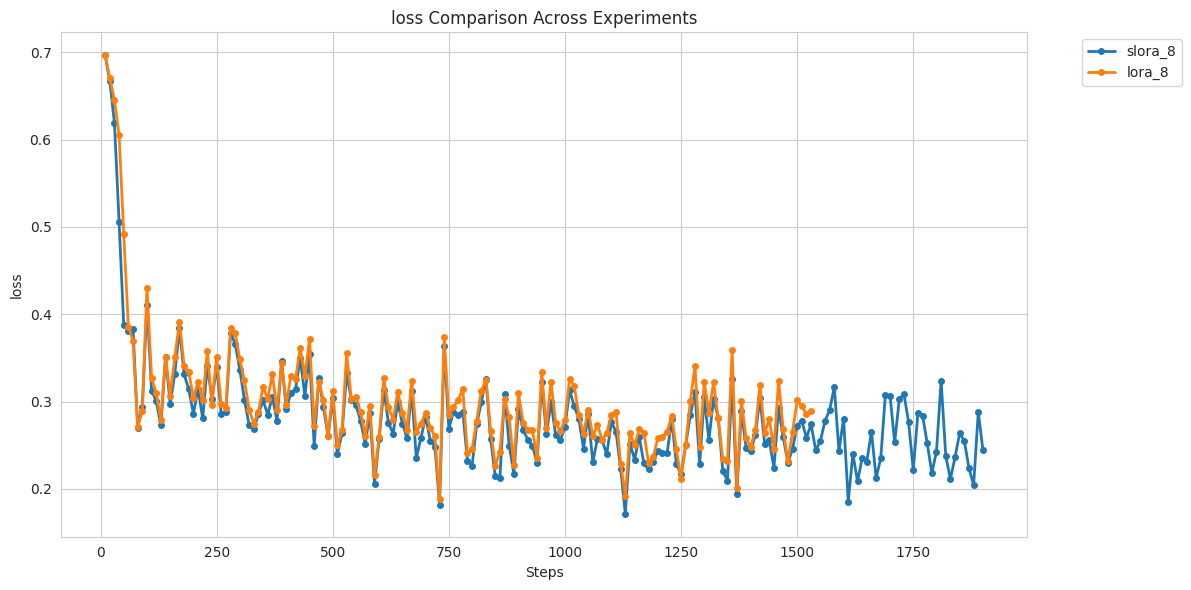

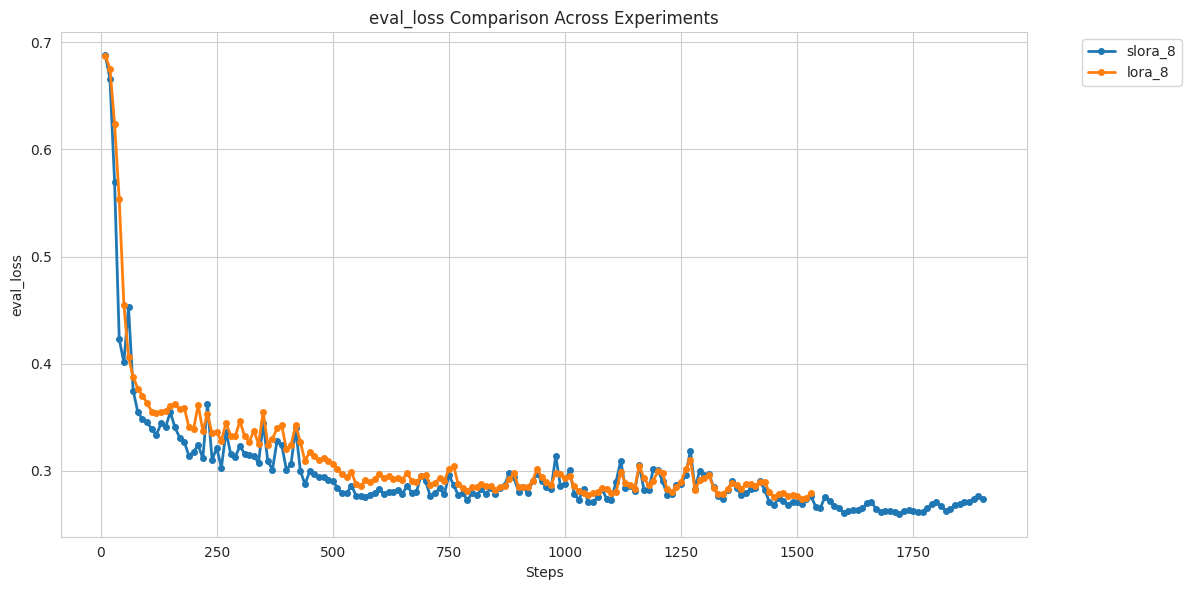

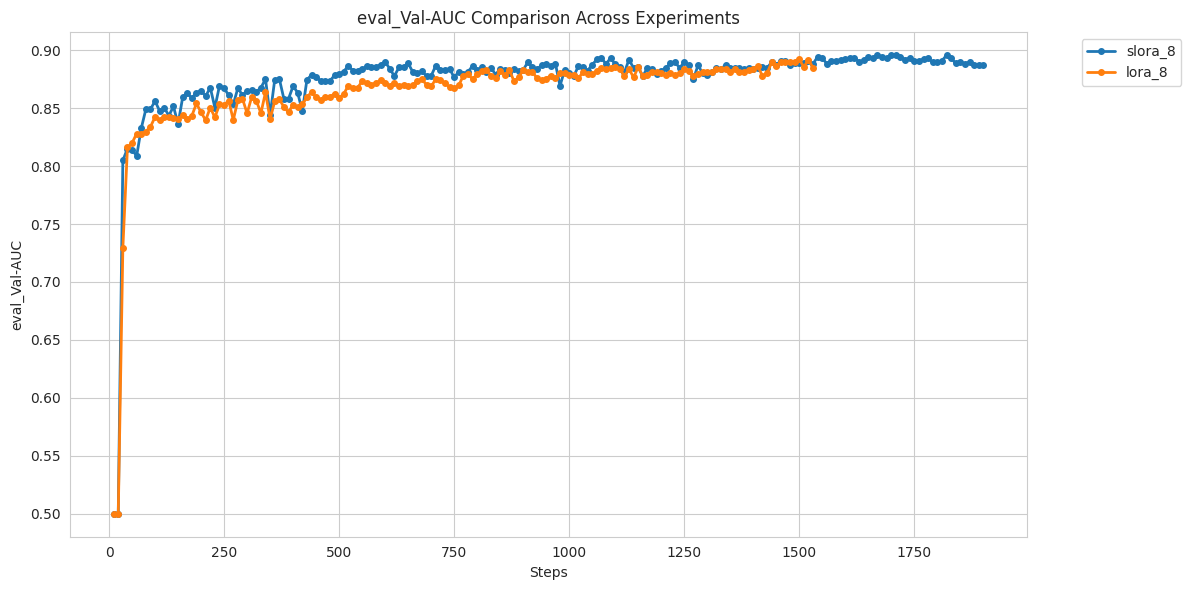

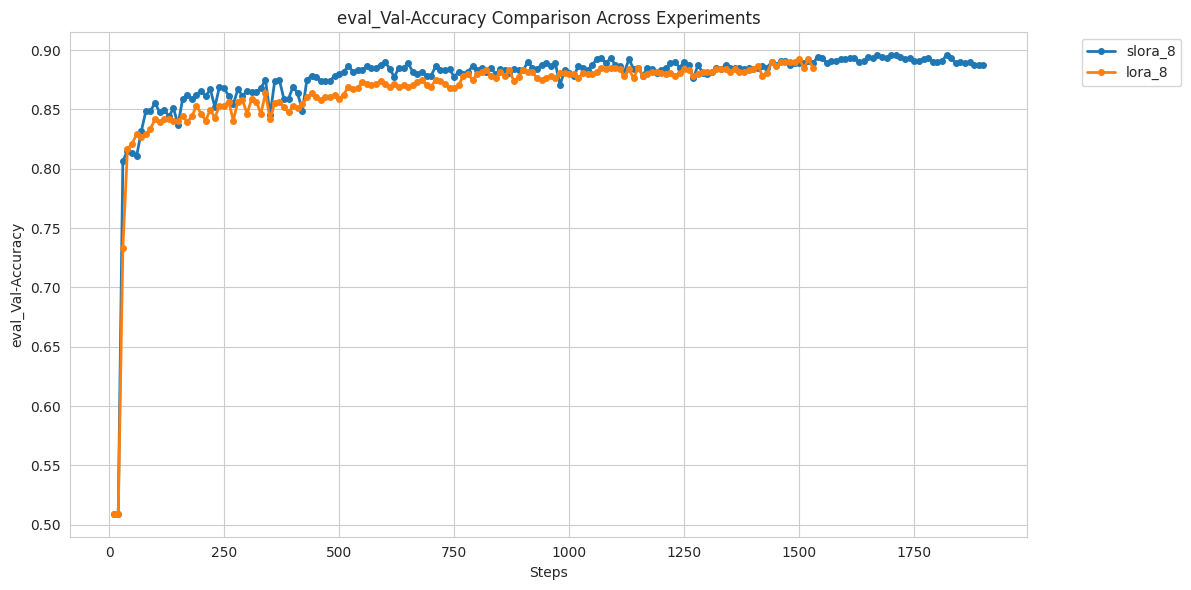

In [18]:
folder = "./sst2-result-distilbert-slora-only-mag/"
pickle_files = [
    folder+'slora_8_history.pkl',
    folder+'lora_8_history.pkl',
    # folder+'pissa_8_history.pkl',
    # folder+'vera_256_history.pkl',
    # folder+'dora_8_history.pkl',
    ]
metrics = ['loss', 'eval_loss', 'eval_Val-AUC', 'eval_Val-Accuracy']
labels = [
    'slora_8', 
    'lora_8', 
    # "pissa_8", 
    # "vera_256",
    # "dora_8"
    ]

# For separate figures
figures = plot_training_metrics(pickle_files, metrics, labels)

# For grid layout
# fig = plot_training_metrics_grid(pickle_files, metrics, labels)
plt.show()

In [19]:
import torch

def extract_and_analyze_diagonal(matrix):
    """
    Extracts diagonal from a matrix and computes its magnitude and direction.
    
    Args:
        matrix (torch.Tensor): Square matrix with diagonal elements
        
    Returns:
        tuple: (diagonal vector, magnitude, direction unit vector)
    """
    # Extract diagonal using torch.diag
    diagonal = torch.diag(matrix)
    
    # Compute magnitude (length) of the diagonal vector
    magnitude = torch.norm(diagonal)
    
    # Compute direction (unit vector)
    # Add small epsilon to avoid division by zero
    direction = diagonal / (magnitude + 1e-8)
    
    return diagonal, magnitude, direction

# Example usage
def demo_diagonal_analysis():
    # Create a sample diagonal matrix
    diagonal_matrix = torch.tensor([
        [2., 0., 0.],
        [0., -3., 0.],
        [0., 0., 4.]
    ])
    
    diagonal, magnitude, direction = extract_and_analyze_diagonal(diagonal_matrix)
    
    print(f"Diagonal vector: {diagonal}")
    print(f"Magnitude: {magnitude:.4f}")
    print(f"Direction unit vector: {direction}")
    
    # Verify that direction is unit vector (magnitude ≈ 1)
    print(magnitude*direction)
    print(f"Direction magnitude (should be ≈ 1): {torch.norm(direction):.4f}")

demo_diagonal_analysis()

Diagonal vector: tensor([ 2., -3.,  4.])
Magnitude: 5.3852
Direction unit vector: tensor([ 0.3714, -0.5571,  0.7428])
tensor([ 2.0000, -3.0000,  4.0000])
Direction magnitude (should be ≈ 1): 1.0000


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SLayer(nn.Module):
    def __init__(self, diagonal_matrix, learn_direction=True, learn_magnitude=True):
        """
        Initialize layer from an existing diagonal matrix's diagonal values.
        
        Args:
            diagonal_matrix (torch.Tensor): Input diagonal matrix to initialize from
            learn_direction (bool): Whether to learn the direction of the diagonal vector
            learn_magnitude (bool): Whether to learn the magnitude scaling
        """
        super().__init__()
        
        # Extract the diagonal values
        init_diagonal = torch.diag(diagonal_matrix)
        init_magnitude = torch.norm(init_diagonal)
        init_direction = init_diagonal / init_magnitude
        
        # Initialize parameters based on learning configuration
        if learn_direction:
            self.direction = nn.Parameter(init_direction)
        else:
            self.register_buffer('direction', init_direction)
            
        if learn_magnitude:
            self.magnitude = nn.Parameter(torch.tensor([init_magnitude]))
        else:
            self.register_buffer('magnitude', torch.tensor([init_magnitude]))
    
    def forward(self, x):
        """
        Forward pass: converts diagonal vector to matrix and applies transformation.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, n)
            
        Returns:
            torch.Tensor: Transformed input using diagonal matrix
        """
        # Normalize direction and scale by magnitude
        normalized_direction = F.normalize(self.direction, dim=0)
        diagonal = normalized_direction * self.magnitude
        
        # Create diagonal matrix for transformation
        diag_matrix = torch.diag(diagonal)
        
        return torch.matmul(x, diag_matrix)
    
    @property
    def diagonal_matrix(self):
        """
        Property to get current diagonal matrix.
        """
        normalized_direction = F.normalize(self.direction, dim=0)
        diagonal = normalized_direction * self.magnitude
        return torch.diag(diagonal)
    
    @property
    def diagonal_vector(self):
        """
        Property to get current diagonal vector.
        """
        normalized_direction = F.normalize(self.direction, dim=0)
        return normalized_direction * self.magnitude

# Example usage
def demo_transform_layer():
    # Create a sample diagonal matrix
    original_matrix = torch.diag(torch.tensor([2., -3., 4.]))
    
    # Create layers with different learning configurations
    layer_full = DiagonalTransformLayer(original_matrix, learn_direction=True, learn_magnitude=True)
    layer_direction = DiagonalTransformLayer(original_matrix, learn_direction=True, learn_magnitude=False)
    layer_magnitude = DiagonalTransformLayer(original_matrix, learn_direction=False, learn_magnitude=True)
    
    print("Original diagonal:", torch.diag(original_matrix))
    print("\nInitialized diagonal vectors:")
    print("Full learning:", layer_full.diagonal_vector)
    print("Direction only:", layer_direction.diagonal_vector)
    print("Magnitude only:", layer_magnitude.diagonal_vector)
    
    # Test forward pass
    x = torch.randn(2, 3)  # batch_size=2, size=3
    out1 = layer_full(x)
    out2 = layer_direction(x)
    out3 = layer_magnitude(x)
    print("\nForward pass output shape:", out1.shape)
    print(out1, out2, out3)

In [21]:
demo_transform_layer()

NameError: name 'DiagonalTransformLayer' is not defined

In [16]:
a = torch.rand(4,4)
a.mannaia = 2

In [15]:
import numpy as np

# Create a sample 2x2 matrix
M = np.array([[2, 1],
              [1, 3]])

# Create a vector
v = np.array([3, 4])

# Calculate magnitude (length) of vector
magnitude = np.linalg.norm(v)  # sqrt(3² + 4²) = 5

# Calculate direction (unit vector)
direction = v / magnitude  # [3/5, 4/5]

print(f"Original vector v: {v}")
print(f"Magnitude: {magnitude}")
print(f"Direction (unit vector): {direction}")

# Method 1: Direct multiplication (M * v)
result1 = M @ v

# Method 2: Using magnitude and direction (M * magnitude * direction)
result2 = M @ (magnitude * direction)

print("\nResult of M * v:")
print(result1)
print("\nResult of M * magnitude * direction:")
print(result2)

# Verify they're equal
print("\nAre results equal?", np.allclose(result1, result2))

Original vector v: [3 4]
Magnitude: 5.0
Direction (unit vector): [0.6 0.8]

Result of M * v:
[10 15]

Result of M * magnitude * direction:
[10. 15.]

Are results equal? True


In [17]:
import numpy as np

# Example setup
M1 = np.array([[2, 1],
               [1, 3]])
M2 = np.array([[1, 2],
               [2, 1]])

# Two diagonal matrices represented by vectors
v1 = np.array([3, 4])
v2 = np.array([6, 8])  # Different magnitude, same direction

# Extract magnitudes
mag1 = np.linalg.norm(v1)  # 5
mag2 = np.linalg.norm(v2)  # 10

# The direction is the same for both
direction = v1 / mag1  # or v2/mag2, they're the same

# Smart average calculation
M_avg = 0.5 * (M1 + M2)
mag_avg = 0.5 * (mag1 + mag2)  # Average the magnitudes

# Final result using averaged magnitude and constant direction
result = mag_avg * (M_avg @ np.diag(direction))

print("Average magnitude:", mag_avg)
print("Constant direction:", direction)
print("\nFinal result:")
print(result)

Average magnitude: 7.5
Constant direction: [0.6 0.8]

Final result:
[[ 6.75  9.  ]
 [ 6.75 12.  ]]


In [19]:
import numpy as np

# Example setup
M1 = np.array([[2, 1],
               [1, 3]])
M2 = np.array([[1, 2],
               [2, 1]])

# Vectors representing diagonal matrices
v1 = np.array([3, 4])
v2 = np.array([6, 8])  # Different magnitude, same direction

# Number of samples/weights for each client (example)
n1 = 100  # samples from client 1
n2 = 200  # samples from client 2
total_samples = n1 + n2

# Federated averaging weights
w1 = n1/total_samples
w2 = n2/total_samples

# 1. Average M using FedAvg weights
M_fedavg = w1 * M1 + w2 * M2

# 2. Average D (through vectors)
# Since direction is constant, we only need to fedavg the magnitudes
mag1 = np.linalg.norm(v1)
mag2 = np.linalg.norm(v2)
direction = v1 / mag1  # constant direction

# Federated average of magnitudes
mag_fedavg = w1 * mag1 + w2 * mag2

# The averaged D can be reconstructed as:
D_fedavg = np.diag(mag_fedavg * direction)

# 3. To get back magnitude from averaged D:
mag_from_D = np.linalg.norm(np.diag(D_fedavg))  # should equal mag_fedavg

print("FedAvg magnitude:", mag_fedavg)
print("Magnitude from averaged D:", mag_from_D)
print("\nAveraged direction (should be constant):", direction)
print("\nFedAvg Matrix M:")
print(M_fedavg)
print("\nFedAvg Diagonal Matrix D:")
print(D_fedavg)

FedAvg magnitude: 8.333333333333332
Magnitude from averaged D: 8.333333333333332

Averaged direction (should be constant): [0.6 0.8]

FedAvg Matrix M:
[[1.33333333 1.66666667]
 [1.66666667 1.66666667]]

FedAvg Diagonal Matrix D:
[[5.         0.        ]
 [0.         6.66666667]]


In [47]:
s_diag = torch.diag(torch.rand(3,3))
a = torch.rand(4,3)
b = torch.rand(4,3)

In [48]:
s_mag = torch.linalg.norm(s_diag)
b_s_mag = s_mag + 0.3
s_dir = s_diag/s_mag
b_s_dir = s_diag/b_s_mag
s_diag,s_mag,s_dir,b_s_mag,b_s_dir

(tensor([0.4137, 0.9555, 0.4452]),
 tensor(1.1324),
 tensor([0.3653, 0.8438, 0.3932]),
 tensor(1.4324),
 tensor([0.2888, 0.6671, 0.3108]))

In [41]:
a@torch.diag(s_diag)

tensor([[0.0123, 0.0891, 0.2377],
        [0.0497, 0.0090, 0.0019],
        [0.1037, 0.0412, 0.4556],
        [0.0145, 0.0918, 0.0872]])

In [83]:
torch.linalg.norm(s_diag),s_mag

(tensor(1.1324), tensor(1.1324))

In [46]:
a *s_mag @ torch.diag(s_dir)

tensor([[0.0123, 0.0891, 0.2377],
        [0.0497, 0.0090, 0.0019],
        [0.1037, 0.0412, 0.4556],
        [0.0145, 0.0918, 0.0872]])

In [ ]:
a *s_mag @ torch.diag(s_dir)

In [66]:
1/2 * (a*s_mag + b*b_s_mag)

tensor([[0.3756, 0.7350, 0.7410],
        [0.8723, 0.5426, 0.5519],
        [0.4710, 1.0984, 0.6119],
        [0.4733, 0.2691, 0.4925]])

In [62]:
((a + b)/2 * (s_mag * b_s_mag)/2) *2

tensor([[0.4466, 0.9946, 0.8617],
        [1.1181, 0.7291, 0.7375],
        [0.5724, 1.4060, 0.7965],
        [0.6318, 0.3148, 0.6783]])

In [67]:
import numpy as np

# Original matrix
M = np.array([[2, 1],
              [1, 3]])

# 1. Separate into magnitude and direction
magnitude = np.linalg.norm(M, 'fro')  # Frobenius norm
direction = M / magnitude  # Normalized matrix

print("Original matrix:")
print(M)
print("\nMagnitude:", magnitude)
print("\nDirection (normalized matrix):")
print(direction)

# 2. Verify we can reconstruct
reconstructed = magnitude * direction
print("\nReconstructed matrix:")
print(reconstructed)
print("\nAre they equal?", np.allclose(M, reconstructed))

# 3. This means when averaging matrices, you could:
M1 = np.array([[2, 1],
               [1, 3]])
M2 = np.array([[4, 2],
               [2, 6]])  # M1 scaled by 2

mag1 = np.linalg.norm(M1, 'fro')
mag2 = np.linalg.norm(M2, 'fro')
dir1 = M1 / mag1
dir2 = M2 / mag2

# If matrices only differ by scale:
print("\nDirections equal?", np.allclose(dir1, dir2))

Original matrix:
[[2 1]
 [1 3]]

Magnitude: 3.872983346207417

Direction (normalized matrix):
[[0.51639778 0.25819889]
 [0.25819889 0.77459667]]

Reconstructed matrix:
[[2. 1.]
 [1. 3.]]

Are they equal? True

Directions equal? True


In [86]:
torch.linalg.norm((a*s_mag+b*b_s_mag)/2)

tensor(2.2208)

In [87]:
(s_mag+b_s_mag)/2

tensor(1.2824)

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NormOnlyLinear(nn.Module):
   def __init__(self, in_features, out_features, norm_type='fro'):
       super().__init__()
       self.norm_type = norm_type
       
   def set_weight_norm(initial_weight=None):
       # Use provided weights or create random ones
       if initial_weight is not None:
           assert initial_weight.shape == (out_features, in_features), \
               f"Weight shape mismatch. Expected {(out_features, in_features)}, got {initial_weight.shape}"
           temp_weight = initial_weight
       else:
           temp_weight = torch.randn(out_features, in_features)
           
       with torch.no_grad():
           # Extract norm and direction
           norm = torch.norm(temp_weight, p=norm_type)
           self.weight_direction = temp_weight / norm
           
       # Only norm is trainable
       self.weight_norm = nn.Parameter(torch.Tensor([norm]))
    #    self.bias = nn.Parameter(torch.zeros(out_features))
       
   def forward(self, x):
       # Reconstruct weight matrix
       weight = self.weight_direction * self.weight_norm
       return F.linear(x, weight,)
   
   @property
   def weight(self):
       """Get current weight matrix"""
       return self.weight_direction * self.weight_norm
   
   def extra_repr(self):
       return (f'in_features={self.weight_direction.size(1)}, '
               f'out_features={self.weight_direction.size(0)}, '
               f'norm_type={self.norm_type}')


# Example usage:
if __name__ == "__main__":
   # Create some initial weights
   init_weight = torch.tensor([[1., 2., 3.],
                             [4., 5., 6.]])
   
   # Create layer with custom weights
   layer = NormOnlyLinear(3, 2, initial_weight=init_weight, norm_type='fro')
   
   # Create layer with random weights
   layer_random = NormOnlyLinear(3, 2, norm_type=2)  # Using spectral norm
   
   # Test both layers
   x = torch.randn(4, 3)  # batch_size=4, in_features=3
   
   print("Layer with custom weights:")
   print("Initial weight norm:", layer.weight_norm.item())
   print("Output shape:", layer(x).shape)
   
   print("\nLayer with random weights:")
   print("Initial weight norm:", layer_random.weight_norm.item())
   print("Output shape:", layer_random(x).shape)
   
   # Verify only norm is trainable
   print("\nTrainable parameters in custom weight layer:")
   for name, param in layer.named_parameters():
       print(f"{name}: requires_grad = {param.requires_grad}")
   
   # Example of different norm types
   norms = ['fro', 2, 1, float('inf')]
   for norm_type in norms:
       layer = NormOnlyLinear(3, 2, initial_weight=init_weight, norm_type=norm_type)
       print(f"\nNorm type {norm_type}:")
       print("Initial norm:", layer.weight_norm.item())
   print(layer.weight_direction)

Layer with custom weights:
Initial weight norm: 9.539392471313477
Output shape: torch.Size([4, 2])

Layer with random weights:
Initial weight norm: 4.17289400100708
Output shape: torch.Size([4, 2])

Trainable parameters in custom weight layer:
weight_norm: requires_grad = True

Norm type fro:
Initial norm: 9.539392471313477

Norm type 2:
Initial norm: 9.539392471313477

Norm type 1:
Initial norm: 21.0

Norm type inf:
Initial norm: 6.0
tensor([[0.1667, 0.3333, 0.5000],
        [0.6667, 0.8333, 1.0000]])


In [104]:
torch.zeros(torch.rand(4,5).shape)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [4]:
import torch
a = torch.rand(3,3)
b = torch.rand(3,3)
s1 = torch.diag(torch.rand(3,3))

In [9]:
mag_s1 = torch.linalg.norm(s1)
mag_s2 = mag_s1 + 0.3
direction = s1/mag_s1
print(mag_s1,mag_s2,direction)

tensor(1.0650) tensor(1.3650) tensor([0.6058, 0.6059, 0.5157])


In [10]:
(a*mag_s1 + b*mag_s2)/2

tensor([[0.5389, 0.7365, 0.8938],
        [0.4997, 1.0391, 0.9420],
        [0.6664, 0.3150, 0.8250]])

In [30]:
((a+b)/2 @ (mag_s1 * torch.eye(3) + mag_s2 *torch.eye(3))/2) - (a*mag_s1 + b*mag_s2)/2

tensor([[-0.0565, -0.0445,  0.0178],
        [ 0.0284, -0.0228, -0.0034],
        [ 0.0363,  0.0188,  0.0408]])

In [2]:
import torch

b1 = torch.rand(4,5)
b2 = torch.rand(4,5)
m1 = torch.rand(1)
m2 = torch.rand(1)

In [11]:
torch.diag(torch.tensor([5.3542, 4.5933, 4.2581, 4.2319, 3.9345, 3.8549, 3.7414, 3.7272]))

tensor([[5.3542, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 4.5933, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 4.2581, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 4.2319, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 3.9345, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.8549, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.7414, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.7272]])

In [16]:
(torch.rand(768,8)@torch.zeros(8,8)@torch.rand(8,768))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])